Ensure that the realistic potential I'll be using is implemented correctly.

In [1]:
from galpy.potential.mwpotentials import McMillan17 as galpy_McM17 #, MWPotential2014
from galpy.potential import plotPotentials, evaluatePotentials
from galpy.util.conversion import get_physical
import astropy.units as u
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
ro = 8 * u.kpc
vo = 220 * u.km/u.s

In [33]:
z_numpy = np.linspace(-1, 1, 100)
z_torch = torch.linspace(-1, 1, 100).to(torch.float64)

In [42]:
def comparison_plot(galpy_potential, pytorch_potential, z, title, fig=None, ax=None, c='k', label='', ncol=1):
    '''
    galpy potential should be in astropy units
    z should be a torch tensor with no units
    '''

    if fig is None or ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace':0.1})
    ax[0].plot(z.numpy(), galpy_potential(z.numpy()*u.kpc), label=label+' galpy', lw=3, c=c, alpha=0.5)
    ax[0].plot(z.numpy(), pytorch_potential(z/ro.value, R=torch.tensor(1.0).to(torch.float64)), linestyle='--', c=c, lw=3, label=label+' orbitflows')
    ax[1].set_xlabel('z (kpc)')
    ax[0].set_ylabel('Potential (km^2/s^2)')

    ax[1].plot(z, galpy_potential(z*u.kpc) - pytorch_potential(z/ro.value, R=torch.tensor(1.0).to(torch.float64)).numpy(), label='Difference', lw=3, c=c)
    ax[1].set_ylabel('Difference (km^2/s^2)')

    ax[0].set_title(title)
    ax[0].legend(ncol=ncol)

    return fig, ax

# NFW

In [43]:
from galpy.potential import NFWPotential as galpy_NFW
from galpy.potential import evaluatePotentials, plotPotentials
from orbitflows import NFWPotential as pytorch_NFW

In [44]:
from orbitflows import NFW_Rforce, normalize_

In [45]:
# comparing Rforce calculation:
print(f'RForce % difference at solar radius: {100 * (galpy_NFW().Rforce(1.0, 0,0) - NFW_Rforce(torch.tensor(0.0), torch.tensor(1.0), torch.tensor(1.0), torch.tensor(1.0)).numpy())/np.mean([galpy_NFW().Rforce(1.0, 0,0), NFW_Rforce(torch.tensor(0.0), torch.tensor(1.0), torch.tensor(1.0), torch.tensor(1.0)).numpy()]):.3e} %')

RForce % difference at solar radius: -9.861e-07 %


In [46]:
# # 1D galpy NFW Potential
# galpy_NFW_1D = partial(evaluatePotentials, galpy_NFW(), 8*u.kpc)

In [47]:
galpy_NFW_1D = partial(galpy_NFW(normalize=0.35, a=2.0), 8*u.kpc)

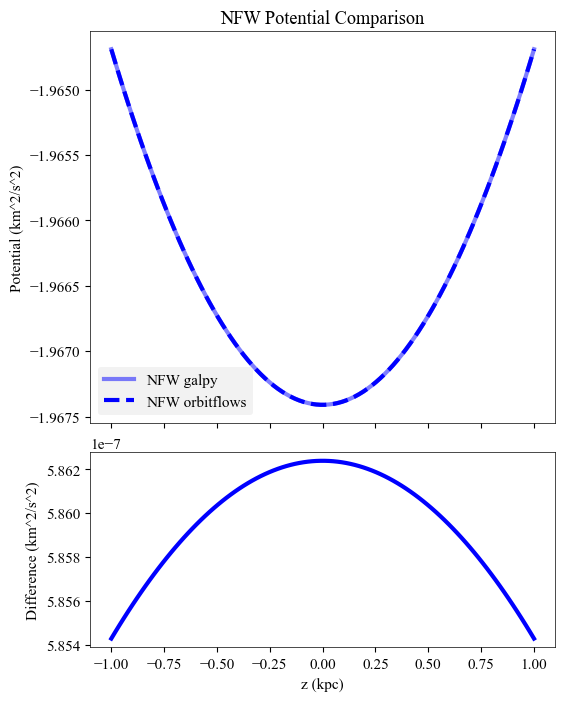

In [48]:
fig, ax = comparison_plot(galpy_NFW_1D, partial(pytorch_NFW, normalize=0.35, a=2.0), z_torch, title='NFW Potential Comparison', label='NFW', c='b')

## `MiyamotoNagaiPotential`

In [49]:
from galpy.potential import MiyamotoNagaiPotential as galpy_MN
from galpy.potential import evaluatePotentials, plotPotentials
from orbitflows import MiyamotoNagaiPotential as pytorch_MN

In [50]:
galpy_MN_1D = partial(galpy_MN(a=3.0 / 8.0, b=0.28 / 8.0, normalize=0.6), 8*u.kpc)

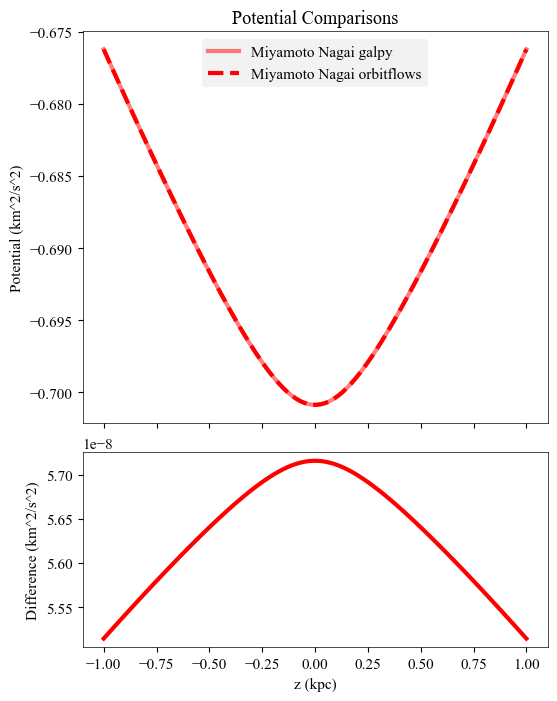

In [51]:
fig_mn, ax_mn = comparison_plot(galpy_MN_1D, partial(pytorch_MN, a=3.0 / 8.0, b=0.28 / 8.0, normalize=0.6), z_torch, title='Potential Comparisons', label='Miyamoto Nagai', c='r')

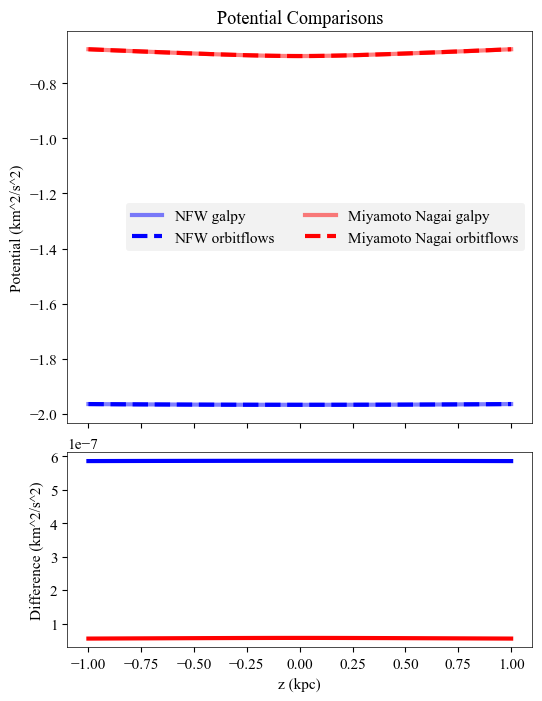

In [52]:
comparison_plot(galpy_MN_1D, partial(pytorch_MN, a=3.0 / 8.0, b=0.28 / 8.0, normalize=0.6), z_torch, title='Potential Comparisons', label='Miyamoto Nagai', fig=fig, ax=ax, c='r', ncol=2)
#comparison_plot(galpy_NFW_1D, partial(pytorch_NFW, normalize=0.35, a=2.0), z_torch, 'NFW Potential Comparison')
fig

# `PowerSphericalPotentialwCutoff`

In [53]:
import scipy
import jax
from orbitflows import hyp1f1

In [56]:
rc = torch.tensor(1.9 / 8.0).to(torch.float64)
alpha = torch.tensor(1.8).to(torch.float64)

In [60]:
(-(z_torch/rc)**2)

tensor([-1.7729e+01, -1.7019e+01, -1.6325e+01, -1.5645e+01, -1.4979e+01,
        -1.4328e+01, -1.3691e+01, -1.3069e+01, -1.2461e+01, -1.1868e+01,
        -1.1289e+01, -1.0725e+01, -1.0175e+01, -9.6394e+00, -9.1184e+00,
        -8.6119e+00, -8.1199e+00, -7.6424e+00, -7.1793e+00, -6.7307e+00,
        -6.2966e+00, -5.8770e+00, -5.4718e+00, -5.0811e+00, -4.7048e+00,
        -4.3430e+00, -3.9957e+00, -3.6629e+00, -3.3446e+00, -3.0407e+00,
        -2.7513e+00, -2.4763e+00, -2.2158e+00, -1.9698e+00, -1.7383e+00,
        -1.5212e+00, -1.3187e+00, -1.1305e+00, -9.5688e-01, -7.9770e-01,
        -6.5299e-01, -5.2276e-01, -4.0699e-01, -3.0570e-01, -2.1887e-01,
        -1.4652e-01, -8.8634e-02, -4.5221e-02, -1.6280e-02, -1.8088e-03,
        -1.8088e-03, -1.6280e-02, -4.5221e-02, -8.8634e-02, -1.4652e-01,
        -2.1887e-01, -3.0570e-01, -4.0699e-01, -5.2276e-01, -6.5299e-01,
        -7.9770e-01, -9.5688e-01, -1.1305e+00, -1.3187e+00, -1.5212e+00,
        -1.7383e+00, -1.9698e+00, -2.2158e+00, -2.4

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_78549/1399173650.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(z_numpy, scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2) - hyp1f1(torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch.to(torch.float32)/rc)**2)).numpy()) #jax.scipy.special.hyp1f1(z_numpy*8,1,-1)), hyp1f1(z_torch*8,torch.tensor(2).to(torch.float64),torch.tensor(-1).to(torch.float64))



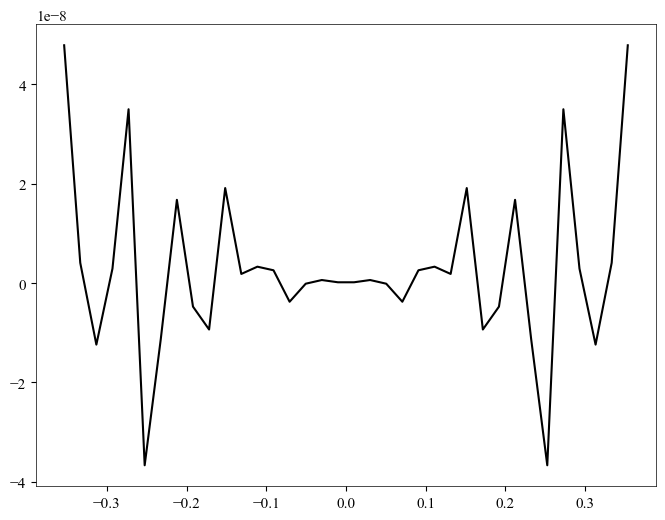

In [67]:
plt.plot(z_numpy, scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2) - hyp1f1(torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch.to(torch.float32)/rc)**2)).numpy()) #jax.scipy.special.hyp1f1(z_numpy*8,1,-1)), hyp1f1(z_torch*8,torch.tensor(2).to(torch.float64),torch.tensor(-1).to(torch.float64))

In [91]:
scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2) - hyp1f1(torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch.to(torch.float64)/rc)**2)).numpy()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_78549/1423581497.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2) - hyp1f1(torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch.to(torch.float64)/rc)**2)).numpy()



tensor([-5.5443e+01, -1.3418e+01, -3.1364e+00, -7.0182e-01, -1.4689e-01,
        -2.6729e-02, -2.9099e-03,  8.5844e-04,  9.4481e-04,  5.8852e-04,
         3.1748e-04,  1.5873e-04,  7.3607e-05,  3.0385e-05,  9.7057e-06,
         6.2412e-07, -2.7080e-06, -3.4363e-06, -3.0976e-06, -2.4051e-06,
        -1.7466e-06, -1.2083e-06, -7.7071e-07, -4.9592e-07, -3.1852e-07,
        -1.8633e-07, -9.9524e-08, -4.1914e-08, -3.4477e-08, -7.5963e-09,
         1.3635e-08, -7.6313e-09,  7.4963e-09,  2.2768e-08, -8.5511e-09,
         6.0102e-09,  2.1472e-08, -1.4586e-08,  9.8847e-10,  1.6718e-08,
         6.1002e-09, -4.0240e-09,  1.0383e-08,  1.0131e-09,  2.9493e-09,
         4.2863e-09, -1.7482e-09, -2.2499e-10,  5.1094e-10,  1.4052e-10,
         1.4052e-10,  5.1094e-10, -2.2499e-10, -1.7482e-09,  4.2863e-09,
         2.9493e-09,  1.0131e-09,  1.0383e-08, -4.0240e-09,  6.1002e-09,
         1.6718e-08,  9.8847e-10, -1.4586e-08,  2.1472e-08,  6.0102e-09,
        -8.5511e-09,  2.2768e-08,  7.4963e-09, -7.6

In [90]:
hyp1f1(torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch.to(torch.float64)/rc)**2)).numpy()

array([55.6025061 , 13.58088559,  3.30367666,  0.87340121,  0.32301282,
        0.20761029,  0.18879187,  0.19028424,  0.19573803,  0.2019361 ,
        0.20837496,  0.21505467,  0.22204392,  0.22940783,  0.23720295,
        0.24548166,  0.25429598,  0.26370051,  0.27375407,  0.28452091,
        0.29607171,  0.30848378,  0.32184137,  0.33623546,  0.3517628 ,
        0.3685246 ,  0.38662436,  0.40616463,  0.42724281,  0.44994559,
        0.47434245,  0.50047783,  0.52836216,  0.55796277,  0.58919423,
        0.62190915,  0.65589071,  0.69084686,  0.72640751,  0.76212591,
        0.79748404,  0.83190292,  0.8647579 ,  0.89539848,  0.92317168,
        0.94744825,  0.96764984,  0.98327545,  0.99392559,  0.99932206,
        0.99932206,  0.99392559,  0.98327545,  0.96764984,  0.94744825,
        0.92317168,  0.89539848,  0.8647579 ,  0.83190292,  0.79748404,
        0.76212591,  0.72640751,  0.69084686,  0.65589071,  0.62190915,
        0.58919423,  0.55796277,  0.52836216,  0.50047783,  0.47

In [85]:
torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch[-1].to(torch.float32)/rc)**2)

(tensor(0.6000, dtype=torch.float64),
 tensor(1.6000, dtype=torch.float64),
 tensor(-17.7285, dtype=torch.float64))

In [86]:
scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_78549/811158563.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2)



tensor([0.1592, 0.1631, 0.1673, 0.1716, 0.1761, 0.1809, 0.1859, 0.1911, 0.1967,
        0.2025, 0.2087, 0.2152, 0.2221, 0.2294, 0.2372, 0.2455, 0.2543, 0.2637,
        0.2738, 0.2845, 0.2961, 0.3085, 0.3218, 0.3362, 0.3518, 0.3685, 0.3866,
        0.4062, 0.4272, 0.4499, 0.4743, 0.5005, 0.5284, 0.5580, 0.5892, 0.6219,
        0.6559, 0.6908, 0.7264, 0.7621, 0.7975, 0.8319, 0.8648, 0.8954, 0.9232,
        0.9474, 0.9676, 0.9833, 0.9939, 0.9993, 0.9993, 0.9939, 0.9833, 0.9676,
        0.9474, 0.9232, 0.8954, 0.8648, 0.8319, 0.7975, 0.7621, 0.7264, 0.6908,
        0.6559, 0.6219, 0.5892, 0.5580, 0.5284, 0.5005, 0.4743, 0.4499, 0.4272,
        0.4062, 0.3866, 0.3685, 0.3518, 0.3362, 0.3218, 0.3085, 0.2961, 0.2845,
        0.2738, 0.2637, 0.2543, 0.2455, 0.2372, 0.2294, 0.2221, 0.2152, 0.2087,
        0.2025, 0.1967, 0.1911, 0.1859, 0.1809, 0.1761, 0.1716, 0.1673, 0.1631,
        0.1592], dtype=torch.float64)

In [68]:
-(z_torch/rc)**2

tensor([-1.7729e+01, -1.7019e+01, -1.6325e+01, -1.5645e+01, -1.4979e+01,
        -1.4328e+01, -1.3691e+01, -1.3069e+01, -1.2461e+01, -1.1868e+01,
        -1.1289e+01, -1.0725e+01, -1.0175e+01, -9.6394e+00, -9.1184e+00,
        -8.6119e+00, -8.1199e+00, -7.6424e+00, -7.1793e+00, -6.7307e+00,
        -6.2966e+00, -5.8770e+00, -5.4718e+00, -5.0811e+00, -4.7048e+00,
        -4.3430e+00, -3.9957e+00, -3.6629e+00, -3.3446e+00, -3.0407e+00,
        -2.7513e+00, -2.4763e+00, -2.2158e+00, -1.9698e+00, -1.7383e+00,
        -1.5212e+00, -1.3187e+00, -1.1305e+00, -9.5688e-01, -7.9770e-01,
        -6.5299e-01, -5.2276e-01, -4.0699e-01, -3.0570e-01, -2.1887e-01,
        -1.4652e-01, -8.8634e-02, -4.5221e-02, -1.6280e-02, -1.8088e-03,
        -1.8088e-03, -1.6280e-02, -4.5221e-02, -8.8634e-02, -1.4652e-01,
        -2.1887e-01, -3.0570e-01, -4.0699e-01, -5.2276e-01, -6.5299e-01,
        -7.9770e-01, -9.5688e-01, -1.1305e+00, -1.3187e+00, -1.5212e+00,
        -1.7383e+00, -1.9698e+00, -2.2158e+00, -2.4

In [69]:
hyp1f1(torch.tensor(1).to(torch.float64),torch.tensor(2).to(torch.float64),torch.tensor(-17).to(torch.float64))

tensor(21.3099, dtype=torch.float64)

In [70]:
scipy.special.hyp1f1(1.5 - alpha / 2.0,
            2.5 - alpha / 2.0,
            -((1 / rc) ** 2.0))

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_78549/1126480494.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scipy.special.hyp1f1(1.5 - alpha / 2.0,



tensor(0.1592, dtype=torch.float64)

In [79]:
torch.tensor(1.5 - alpha / 2.0).to(torch.float64), torch.tensor(2.5 - alpha / 2.0).to(torch.float64), torch.tensor(-((torch.tensor(1) / rc) ** 2.0).to(torch.float32))

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_78549/924620238.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(1.5 - alpha / 2.0).to(torch.float64), torch.tensor(2.5 - alpha / 2.0).to(torch.float64), torch.tensor(-((torch.tensor(1) / rc) ** 2.0).to(torch.float32))



(tensor(0.6000, dtype=torch.float64),
 tensor(1.6000, dtype=torch.float64),
 tensor(-17.7285))

In [83]:
hyp1f1(torch.tensor(1.5 - alpha / 2.0).to(torch.float64),
            torch.tensor(2.5 - alpha / 2.0).to(torch.float64),
            torch.tensor(-((torch.tensor(1) / rc) ** 2.0)).to(torch.float32),)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_78549/1997848266.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hyp1f1(torch.tensor(1.5 - alpha / 2.0).to(torch.float64),

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_78549/1997848266.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(2.5 - alpha / 2.0).to(torch.float64),

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_78549/1997848266.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(-((torch.tensor(1) / rc) ** 2.0)).to

tensor(nan, dtype=torch.float64)

In [23]:
from galpy.potential import SCFPotential, DiskSCFPotential

In [24]:
from galpy.potential import PowerSphericalPotentialwCutoff as galpy_pspc
from galpy.potential import evaluatePotentials, plotPotentials
from orbitflows import PowerSphericalPotentialwCutoff as pytorch_pspc

ImportError: cannot import name 'PowerSphericalPotentialwCutoff' from 'orbitflows' (/Users/gabrielpfaffman/Repos/orbitflows/orbitflows/__init__.py)

In [ ]:
torch.special.gammaln(torch.tensor(10)).exp(), np.exp(scipy.special.gammaln(10)), scipy.special.gamma(10)

(tensor(362880.), np.float64(362879.9999999998), np.float64(362880.0))

# `MWPotential2014`

## galpy `galpy_McM17` Potential

In [ ]:
r0 = get_physical(galpy_McM17)['ro']

In [ ]:
galpy_pot = galpy_McM17
galpy_1D_McM = partial(evaluatePotentials, galpy_McM17, 1.0)

Text(0, 0.5, 'Difference (km^2/s^2)')

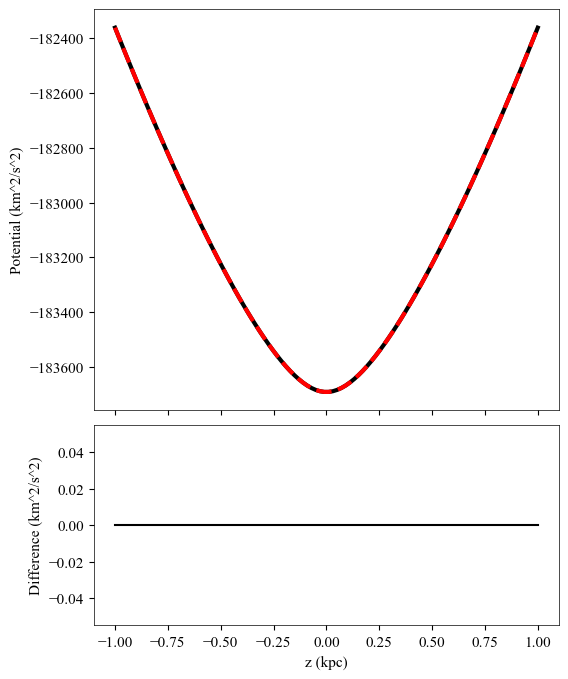

In [ ]:
zlist = np.linspace(-1, 1, 100)
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace':0.05})
ax[0].plot(zlist, galpy_1D_McM(zlist/r0), lw=3, label='unitless galpy_McM17')
ax[0].plot(zlist, evaluatePotentials(galpy_McM17, r0*u.kpc, zlist*u.kpc), c='r', linestyle='--', lw=3, label='galpy_McM17 w/ units')

ax[0].set_ylabel('Potential (km^2/s^2)')

ax[1].plot(zlist, galpy_1D_McM(zlist/8.21) - evaluatePotentials(galpy_McM17, 8.21*u.kpc, zlist*u.kpc))
ax[1].set_xlabel('z (kpc)')
ax[1].set_ylabel('Difference (km^2/s^2)')

## pytorch implementation

In [ ]:
from orbitflows import McMillan17 as pytorch_McM17

ImportError: cannot import name 'McMillan17' from 'orbitflows' (/Users/gabrielpfaffman/Repos/orbitflows/orbitflows/__init__.py)